# Sentiment Analysis and Topic modelling on Amazon reviews.

## Team

Mayank Varshney, Sahil Dhingra, Prasad Prakash Yacham 

# Import required Libraries

In [322]:
import pandas as pd
import gzip
import numpy as np

import re
import string

# Required for Pre Processing
#HTML Stripping
from bs4 import BeautifulSoup
# Unicode Conversion
import unicodedata


import nltk
from nltk.stem import WordNetLemmatizer

# Model Creation, Vectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier, LogisticRegression
import joblib
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from wordcloud import WordCloud
from termcolor import colored

import pyLDAvis
from pyLDAvis.sklearn import prepare

# Import the python files 
import text_normalizer as tn
import model_evaluation_utils as meu

# Sentiment Analysis
import textblob
from afinn import Afinn
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Load the data into dataframes

Data was downloaded from https://nijianmo.github.io/amazon/index.html.

Following categories were selected for this project
1. Automobile
2. Gift Cards
3. Softwares
4. Magazine Subscriptions

In [323]:
# Import the software Reviews data into a dataframe and select the required columns
df_softwares = pd.read_json(
        'Software.json.gz',
        lines=True,
        compression='gzip'
    )

df_softwares['Category'] = 'Softwares'

df_softwares = df_softwares[['reviewerID','asin','reviewText','Category','unixReviewTime','overall']]
df_softwares.head(5)

,reviewerID,asin,reviewText,Category,unixReviewTime,overall
0,A240ORQ2LF9LUI,0077613252,The materials arrived early and were in excell...,Softwares,1394496000,4
1,A1YCCU0YRLS0FE,0077613252,I am really enjoying this book with the worksh...,Softwares,1393113600,4
2,A1BJHRQDYVAY2J,0077613252,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",Softwares,1392595200,1
3,APRDVZ6QBIQXT,0077613252,This book was missing pages!!! Important pages...,Softwares,1392595200,3
4,A2JZTTBSLS1QXV,0077775473,I have used LearnSmart and can officially say ...,Softwares,1381708800,5


In [324]:
# Import the Magazine Reviews data into a dataframe and select the required columns
df_magazine = pd.read_json(
        'Magazine_Subscriptions.json.gz',
        lines=True,
        compression='gzip'
    )

df_magazine['Category'] = 'Magazine Subscriptions'

df_magazine = df_magazine[['reviewerID','asin','reviewText','Category','unixReviewTime','overall']]
df_magazine.head(5)

,reviewerID,asin,reviewText,Category,unixReviewTime,overall
0,AH2IFH762VY5U,B00005N7P0,"for computer enthusiast, MaxPC is a welcome si...",Magazine Subscriptions,1005177600,5
1,AOSFI0JEYU4XM,B00005N7P0,Thank god this is not a Ziff Davis publication...,Magazine Subscriptions,1004486400,5
2,A3JPFWKS83R49V,B00005N7OJ,Antiques Magazine is a publication made for an...,Magazine Subscriptions,1174694400,3
3,A19FKU6JZQ2ECJ,B00005N7OJ,This beautiful magazine is in itself a work of...,Magazine Subscriptions,1163116800,5
4,A25MDGOMZ2GALN,B00005N7P0,A great read every issue.,Magazine Subscriptions,1405296000,5


In [325]:
# Import the gift card Reviews data into a dataframe and select the required columns
df_gc = pd.read_json(
        'Gift_Cards.json.gz',
        lines=True,
        compression='gzip'
    )

df_gc['Category'] = 'Gift Card'

df_gc = df_gc[['reviewerID','asin','reviewText','Category','unixReviewTime','overall']]
df_gc.head(5)

,reviewerID,asin,reviewText,Category,unixReviewTime,overall
0,APV13CM0919JD,B001GXRQW0,"Amazon,\nI am shopping for Amazon.com gift car...",Gift Card,1229644800,1
1,A3G8U1G1V082SN,B001GXRQW0,"I got this gift card from a friend, and it was...",Gift Card,1229472000,5
2,A11T2Q0EVTUWP,B001GXRQW0,aren't we going to save trees?! :) People who ...,Gift Card,1229472000,5
3,A9YKGBH3SV22C,B001GXRQW0,You can always get someone something from Amaz...,Gift Card,1229472000,5
4,A34WZIHVF3OKOL,B001GXRQW0,Why take 50 dollars of good money with no limi...,Gift Card,1229472000,1


In [326]:
# Import the automobile Reviews data into a dataframe and select the required columns
df_auto = pd.read_json(
        'reviews_Automotive_5.json.gz',
        lines=True,
        compression='gzip'
    )

df_auto['Category'] = 'Automotive'

df_auto = df_auto[['reviewerID','asin','reviewText','Category','unixReviewTime','overall']]
df_auto.head(5)

,reviewerID,asin,reviewText,Category,unixReviewTime,overall
0,A3F73SC1LY51OO,B00002243X,I needed a set of jumper cables for my new car...,Automotive,1313539200,5
1,A20S66SKYXULG2,B00002243X,"These long cables work fine for my truck, but ...",Automotive,1315094400,4
2,A2I8LFSN2IS5EO,B00002243X,Can't comment much on these since they have no...,Automotive,1374710400,5
3,A3GT2EWQSO45ZG,B00002243X,I absolutley love Amazon!!! For the price of ...,Automotive,1292889600,5
4,A3ESWJPAVRPWB4,B00002243X,I purchased the 12' feet long cable set and th...,Automotive,1341360000,5


In [327]:
# Merge all the categories data into a single data frame
df = [df_auto, df_gc, df_softwares, df_magazine]
df_reviews = pd.concat(df)
#df_reviews = df_auto
df_reviews.head()

,reviewerID,asin,reviewText,Category,unixReviewTime,overall
0,A3F73SC1LY51OO,B00002243X,I needed a set of jumper cables for my new car...,Automotive,1313539200,5
1,A20S66SKYXULG2,B00002243X,"These long cables work fine for my truck, but ...",Automotive,1315094400,4
2,A2I8LFSN2IS5EO,B00002243X,Can't comment much on these since they have no...,Automotive,1374710400,5
3,A3GT2EWQSO45ZG,B00002243X,I absolutley love Amazon!!! For the price of ...,Automotive,1292889600,5
4,A3ESWJPAVRPWB4,B00002243X,I purchased the 12' feet long cable set and th...,Automotive,1341360000,5


#### Data Cleansing 

This is required to make the data suitable for modelling and performing LDA/sentiment analysis

In [328]:
# Function to comvert the reviews date into DATE format from utc format

from datetime import datetime

# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case

def date_conversion(x):
    return datetime.utcfromtimestamp(x).strftime('%Y-%m-%d')

In [329]:
# Call the function for date conversion
df_reviews['unixReviewTime'] = df_reviews['unixReviewTime'].apply(date_conversion)

# Create a column to define the sentiment based on the user ratings provided
df_reviews['sentiment'] = df_reviews['overall'].apply(lambda overall : 'positive' if overall >= 3 else 'negative')
df_reviews.head()

,reviewerID,asin,reviewText,Category,unixReviewTime,overall,sentiment
0,A3F73SC1LY51OO,B00002243X,I needed a set of jumper cables for my new car...,Automotive,2011-08-17,5,positive
1,A20S66SKYXULG2,B00002243X,"These long cables work fine for my truck, but ...",Automotive,2011-09-04,4,positive
2,A2I8LFSN2IS5EO,B00002243X,Can't comment much on these since they have no...,Automotive,2013-07-25,5,positive
3,A3GT2EWQSO45ZG,B00002243X,I absolutley love Amazon!!! For the price of ...,Automotive,2010-12-21,5,positive
4,A3ESWJPAVRPWB4,B00002243X,I purchased the 12' feet long cable set and th...,Automotive,2012-07-04,5,positive


In [330]:
df_reviews.info()
df_reviews.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20473 entries, 0 to 20472
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      20473 non-null  object
 1   asin            20473 non-null  object
 2   reviewText      20473 non-null  object
 3   Category        20473 non-null  object
 4   unixReviewTime  20473 non-null  object
 5   overall         20473 non-null  int64 
 6   sentiment       20473 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


reviewerID        object
asin              object
reviewText        object
Category          object
unixReviewTime    object
overall            int64
sentiment         object
dtype: object

In [331]:
# Find empty review records from the dataset
empty_reviews = df_reviews[df_reviews.reviewText.str.strip() == ''].shape[0]
print("Empty documents:", empty_reviews)

Empty documents: 6


In [332]:
df_reviews = df_reviews.replace(r'^(\s?)+$', np.nan, regex=True)
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20473 entries, 0 to 20472
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      20473 non-null  object
 1   asin            20473 non-null  object
 2   reviewText      20467 non-null  object
 3   Category        20473 non-null  object
 4   unixReviewTime  20473 non-null  object
 5   overall         20473 non-null  int64 
 6   sentiment       20473 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


In [333]:
# Remove all records with null values in any of the columns
df_reviews = df_reviews.dropna().reset_index(drop=True)
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20467 entries, 0 to 20466
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      20467 non-null  object
 1   asin            20467 non-null  object
 2   reviewText      20467 non-null  object
 3   Category        20467 non-null  object
 4   unixReviewTime  20467 non-null  object
 5   overall         20467 non-null  int64 
 6   sentiment       20467 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


### Pre processing Logic

Created  user defined functions to pre-process the corpus:
1. strip_ html tags function is used to cleaning text-strip the HTML
2. remove accented chars function is used to remove accented characters
3. expand contractions function is used for expand contractions[I'm ->| am]
4. Other functionalities are within the below function for normalization. 
5. Remove numbers.
6. Remove stopwards:
        - In stop wards, we have removed some negation words which will be useful for the sentiment analysis    which   otherwise are deleted from the pre-defined list.
        - There are words which are added to the list as well. Reason being, many of the comments will have reference to amazon or delivery or item. Since this is e-commerce, these words are just fillers for the product  and product details. Therefore, they really do not fit into the corpus for topic modelling.
7. Lemmatization and Stemming: We did went ahead with Lemmatization and Stemming earlier but during LDA, we realized that words from the topics were coming from the original form of the words which made it very unclear what the user is saying about a product. Therefore, we mantained the form of the words and put a few generic words like (bought, arrived,fits") which do not add any value.

In [334]:
# Function to remove the puncuations from the document 
def remove_punctuations(document):
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filteredtokens =  re.sub(pattern,'', document)
    return filteredtokens

# Function to remove the stopwords from the token list
#def remove_stopwords(tokens):
#    nltk_stopwords  = nltk.corpus.stopwords.words('english')
#    filtered_tokens = [token for token in tokens if token.lower() not in nltk_stopwords]
#    return filtered_tokens

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def get_stopwords():
    nltk_stopwords  = nltk.corpus.stopwords.words('english')
    nltk_stopwords.remove('no')
    nltk_stopwords.remove('but')
    nltk_stopwords.remove('not')
    new_words = ["absolutley","amazon","anymore","arrive","arrived","box","buy","dollar","like","set","use","used","ha","all","product","does"]
    nltk_stopwords.extend(new_words)
    
    return nltk_stopwords

# Function to remove the stopwords from the token list
def remove_stopwords(tokens):
    stopwords = get_stopwords()
    #nltk_stopwords  = nltk.corpus.stopwords.words('english')
    #nltk_stopwords.remove('no')
    #nltk_stopwords.remove('but')
    #nltk_stopwords.remove('not')
    #new_words = ["absolutley","amazon","anymore","arrive","arrived","box","buy","dollar","like","set","use","used","ha","all","product","does"]
    #nltk_stopwords.extend(new_words)
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    return filtered_tokens


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [335]:
# Function to pre-process the corpus
def normalize_document(data,accented_char_removal=True, html_stripping=True,remove_digits = True,remove_stopword= True,
                       text_lemmatization=True, text_stemmer=False):
    # List to hold the normlized data after tokenizing 
    normalized_data = []
    
    lemmatizer = WordNetLemmatizer()
    
    for doc in data:
        # Remove the digits from the data
        #doc = re.sub(r'[^a-zA-Z\s]', '', doc)
        doc = re.sub(r'\b\d+\b', '', doc)
        
        # Convert each sentence into lower case and strip the extra spaces
        doc = doc.lower()
        doc = doc.strip()
        
        doc = remove_punctuations(doc)
        
        # Normalize unicode characters
        if accented_char_removal:
                doc = remove_accented_chars(doc)

        # remove html tags
        if html_stripping:
                doc = strip_html_tags(doc)

        
        if text_lemmatization:
            word_list = nltk.word_tokenize(doc)
            doc = ' '.join([lemmatizer.lemmatize(w) for w in word_list]) 
        
        # tokenize document into words
        tokens = nltk.word_tokenize(doc)
        
        # remove stopwords out of document
        if remove_stopword:
            no_stopwords_tokens = remove_stopwords(tokens)
        
        # re-create document from filtered tokens
        doc = ' '.join(no_stopwords_tokens)
        
        if text_stemmer:
            ps = nltk.porter.PorterStemmer()
            doc = ' '.join([ps.stem(word) for word in doc.split()])
        
        # append preprocessed document to the list
        normalized_data.append(doc)
        
    return normalized_data



In [336]:
norm_corpus = normalize_document(df_reviews['reviewText'],accented_char_removal=True, html_stripping=True,remove_digits = True,remove_stopword= True,
                       text_lemmatization=False, text_stemmer=False)

In [337]:
df_reviews['Clean_Reviews'] = norm_corpus

In [338]:
df_reviews.head()

,reviewerID,asin,reviewText,Category,unixReviewTime,overall,sentiment,Clean_Reviews
0,A3F73SC1LY51OO,B00002243X,I needed a set of jumper cables for my new car...,Automotive,2011-08-17,5,positive,needed jumper cables new car good reviews good...
1,A20S66SKYXULG2,B00002243X,"These long cables work fine for my truck, but ...",Automotive,2011-09-04,4,positive,long cables work fine truck but quality seems ...
2,A2I8LFSN2IS5EO,B00002243X,Can't comment much on these since they have no...,Automotive,2013-07-25,5,positive,cant comment much since not yet come back upda...
3,A3GT2EWQSO45ZG,B00002243X,I absolutley love Amazon!!! For the price of ...,Automotive,2010-12-21,5,positive,love price cheap boosterjumper cables brick mo...
4,A3ESWJPAVRPWB4,B00002243X,I purchased the 12' feet long cable set and th...,Automotive,2012-07-04,5,positive,purchased feet long cable retail cardboard han...


In [339]:
df_auto_reviews = df_reviews[df_reviews.Category=='Automotive']
df_gc_reviews = df_reviews[df_reviews.Category=='Gift Card']
df_software_reviews = df_reviews[df_reviews.Category=='Softwares']
df_magazine_reviews = df_reviews[df_reviews.Category=='Magazine Subscriptions']

In [340]:
df_auto_reviews.head()

,reviewerID,asin,reviewText,Category,unixReviewTime,overall,sentiment,Clean_Reviews
0,A3F73SC1LY51OO,B00002243X,I needed a set of jumper cables for my new car...,Automotive,2011-08-17,5,positive,needed jumper cables new car good reviews good...
1,A20S66SKYXULG2,B00002243X,"These long cables work fine for my truck, but ...",Automotive,2011-09-04,4,positive,long cables work fine truck but quality seems ...
2,A2I8LFSN2IS5EO,B00002243X,Can't comment much on these since they have no...,Automotive,2013-07-25,5,positive,cant comment much since not yet come back upda...
3,A3GT2EWQSO45ZG,B00002243X,I absolutley love Amazon!!! For the price of ...,Automotive,2010-12-21,5,positive,love price cheap boosterjumper cables brick mo...
4,A3ESWJPAVRPWB4,B00002243X,I purchased the 12' feet long cable set and th...,Automotive,2012-07-04,5,positive,purchased feet long cable retail cardboard han...


In [341]:
df_reviews.to_csv('df_reviews')
df_auto_reviews.to_csv('df_auto_reviews')
df_gc_reviews.to_csv('df_gc_reviews')
df_software_reviews.to_csv('df_software_reviews')
df_magazine_reviews.to_csv('df_magazine_reviews')

## Feature Extraction: TfIDF Vectorizer

Vectorization is performed separately for sentiment analysis and we have different parameters for the max, and min df. We could optimize the function by parametrizing the variables as well

In [342]:
# For each category, we are spitting the data and creating train and test frames.
def data_split(df_category):
    train_data, test_data =train_test_split(df_category, 
                                                         test_size=0.3, random_state=42)
    
    return train_data, test_data

In [343]:
# Function to split the reviews data into training and test data, perform TF_IDF vectorization

def split_vectorization(train_data, test_data):

    #train_data, test_data =data_split(df_category)

    # experiments with different settings results yields the following hyperparameters
    vectorizer = TfidfVectorizer(max_df=.11, 
                                 min_df=.026, 
                                 stop_words='english')

    train_dtm = vectorizer.fit_transform(train_data.Clean_Reviews)
    words = vectorizer.get_feature_names()

    test_dtm = vectorizer.transform(test_data.Clean_Reviews)

    print('TFIDF model: \n\nTrain features shape:', train_dtm.shape, '\nTest features shape:', test_dtm.shape)
    
    return train_dtm , test_dtm , words

In [344]:
auto_train_data, auto_test_data =data_split(df_auto_reviews)
auto_train_dtm, auto_test_dtm, auto_words = split_vectorization(auto_train_data, auto_test_data)

TFIDF model: 

Train features shape: (14326, 188) 
Test features shape: (6141, 188)


/Users/mayankvarshney/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### LDA

##### Set the path to current working directory

In [345]:
# Set the path to current working directory 
DATA_DIR = Path().absolute()
data_path = DATA_DIR / 'df_auto_reviews'

results_path = Path('results')
model_path = Path('results', 'amzn_auto_rw')
if not model_path.exists():
    model_path.mkdir(exist_ok=True, parents=True)

In [346]:
n_components = 10
topic_labels = [f'Topic {i}' for i in range(1, n_components+1)]

def lda(train_data):
    lda_base = LatentDirichletAllocation(n_components=n_components,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=10)
    lda_base.fit(train_data)
    
    joblib.dump(lda_base, model_path / 'lda_10_iter.pkl')
    lda_base = joblib.load(model_path / 'lda_10_iter.pkl') 
    return lda_base

The model tracks the in-sample perplexity during training and stops iterating once this measure stops improving. We can persist and load the result as usual with sklearn objects:

In [347]:
lda_auto = lda(auto_train_dtm)
lda_auto

LatentDirichletAllocation(n_jobs=-1)

In [348]:
def topic_modelling(lda, words):
    topics_count = lda.components_
    topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
    topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
    top_words = {}
    for topic, words_ in topics.items():
        top_words[topic] = words_.nlargest(10).index.tolist()
    df_words = pd.DataFrame(top_words)
    #print (top_words)
    return df_words, topics

    

In [349]:
df_topics_auto, topics  = topic_modelling(lda_auto,auto_words)
df_topics_auto.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,fit,recommend,trailer,light,oil,tire,install,tool,wax,battery
1,money,store,quality,lights,filter,tires,wiper,hose,wash,power
2,worth,ones,price,bright,engine,pressure,jeep,item,clean,charge
3,look,highly,wheel,fits,change,water,rv,kit,paint,unit
4,truck,bought,cover,perfectly,air,heavy,windshield,needed,shine,plug


In [350]:
def topic_charts(topics):
    fig, ax = plt.subplots(figsize=(10, 14))
    sns.heatmap(topics.sort_values(topic_labels, ascending=False),
                cmap='Blues', ax=ax, cbar_kws={'shrink': .6})
    fig.tight_layout()
    
    
    fig, axes = plt.subplots(nrows=10, sharey=True, sharex=True, figsize=(10, 15))
    for i, (topic, prob) in enumerate(topics.items()):
        sns.distplot(prob, ax=axes[i], bins=100, kde=False, norm_hist=False)
        axes[i].set_yscale('log')
        axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    fig.suptitle('Topic Distributions')
    sns.despine()
    fig.tight_layout()
    

/Users/mayankvarshney/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


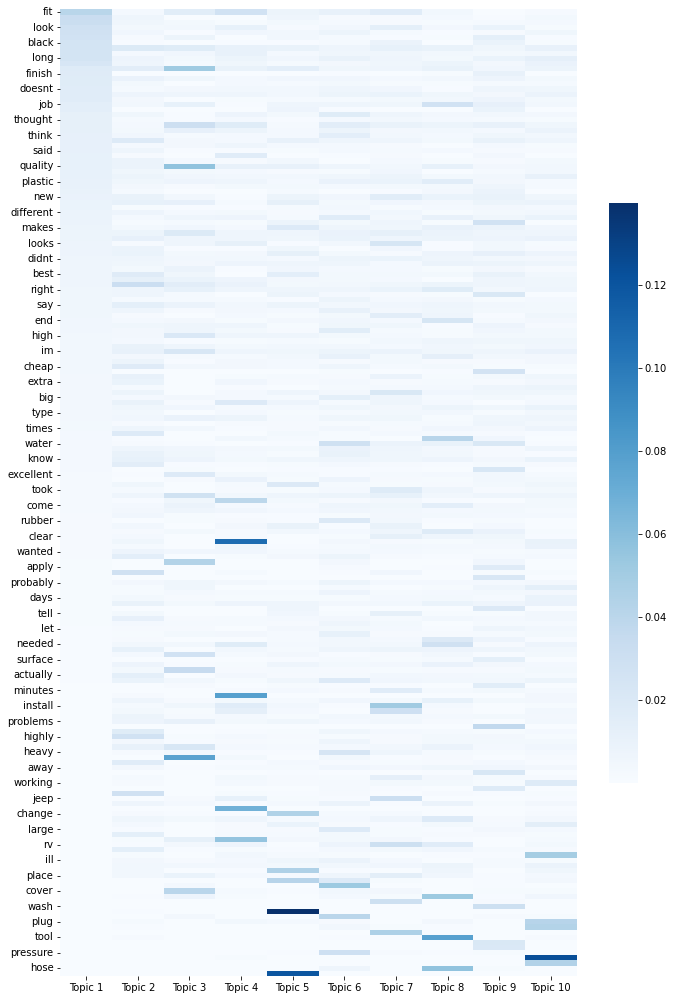

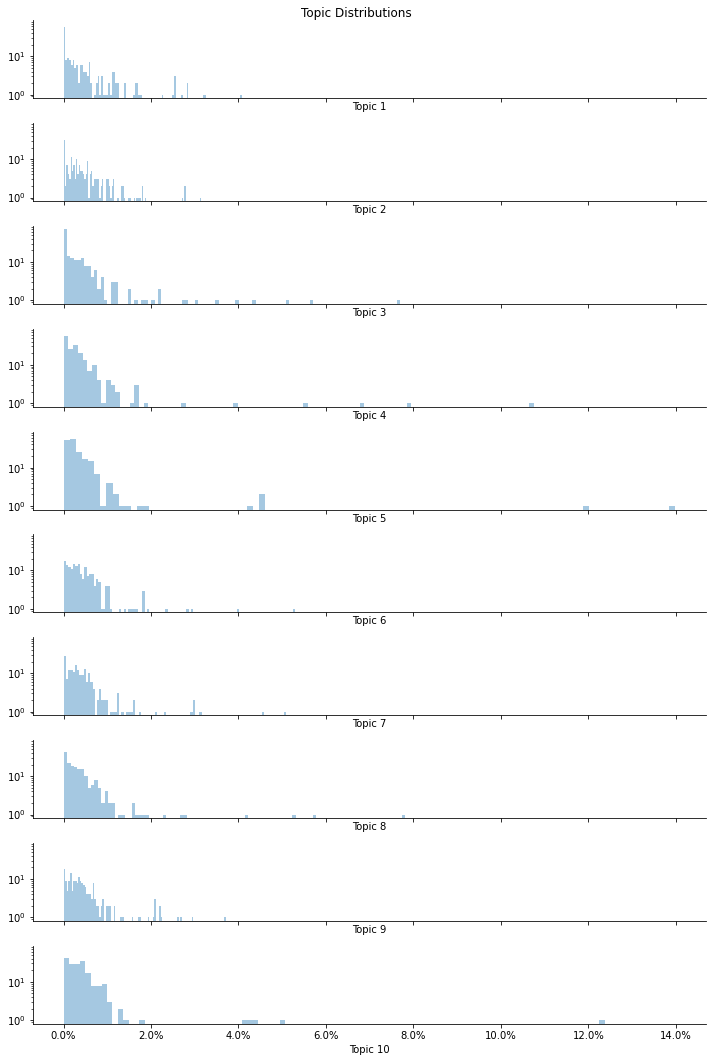

In [351]:
topic_charts(topics)

##### It can be clearly seen that our data is highly skewed which is the reason why we have used log scale for out y-axis.

In [352]:
def evaluate(lda_base,train_dtm,test_dtm, train_data):
    train_preds = lda_base.transform(train_dtm)
    train_preds.shape
    train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_data['Clean_Reviews'])
    #print(train_eval.head())
    test_preds = lda_base.transform(test_dtm)
    test_eval = pd.DataFrame(test_preds, columns=topic_labels)
    return train_eval, test_eval

In [353]:
train_eval, test_eval = evaluate(lda_auto, auto_train_dtm,auto_test_dtm, auto_train_data)

### PyLDAVis
LDAvis helps you interpret LDA results by answer 3 questions:
What is the meaning of each topic?
How prevalent is each topic?
How do topics relate to each other?

Save the best model again
All in allwe saved 3 models:
Initial test model
Optimized model
Final Model. Model with full dataset.

In [354]:
def topic_all_data(df):
    vectorizer = CountVectorizer(max_df=.5, 
                             min_df=5,
                             stop_words='english',
                             max_features=2000)
    dtm = vectorizer.fit_transform(df.Clean_Reviews)
    
    lda_all = LatentDirichletAllocation(n_components=10,
                                    max_iter=500,
                                    learning_method='batch',
                                    evaluate_every=10,
                                    random_state=42,
                                    verbose=1)
    lda_all.fit(dtm)
    
    joblib.dump(lda_all, model_path /'lda_all.pkl')
    
    # Fit the LDA model on the vectorized data
    lda_all = joblib.load(model_path / 'lda_all.pkl') 
    
    prepare(lda_all, dtm, vectorizer)
    
    topics_prob = lda_all.components_ / lda_all.components_.sum(axis=1).reshape(-1, 1)
    topics = pd.DataFrame(topics_prob.T,
                      index=vectorizer.get_feature_names(),
                      columns=topic_labels)
    
    print ('Visualize topic-word assocations per document')

    w = WordCloud()
    fig, axes = plt.subplots(nrows=10, figsize=(15, 30))
    axes = axes.flatten()
    for t, (topic, freq) in enumerate(topics.items()):
        w.generate_from_frequencies(freq.to_dict())
        axes[t].imshow(w, interpolation='bilinear')
        axes[t].set_title(topic, fontsize=18)
        axes[t].axis('off')
    plt.show()
    
    dtm_ = pd.DataFrame(data=lda_all.transform(dtm),
                    columns=topic_labels
                    )

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 913.0472
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 902.4860
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500
iteration: 30 of max_iter: 500, perplexity: 900.8027
iteration: 31

/Users/mayankvarshney/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/mayankvarshney/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/mayankvarshney/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mayankvarshney/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module

Visualize topic-word assocations per document


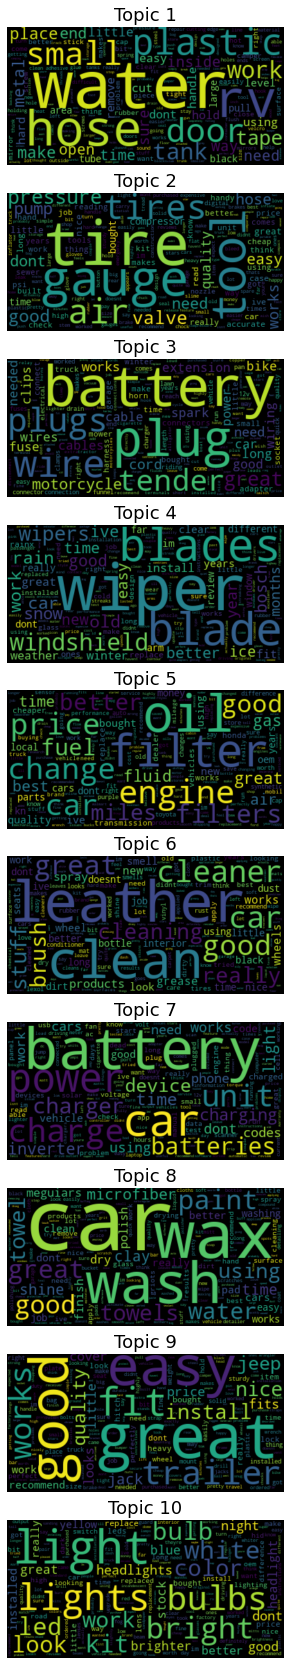

In [355]:
topic_all_data(df_auto_reviews)

## Sentiment Analysis

#Define the models: LR and SVM

In [356]:
nltk.download('stopwords')
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mayankvarshney/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/mayankvarshney/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mayankvarshney/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mayankvarshney/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mayankvarshney/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [357]:
lr = LogisticRegression(penalty='l2', max_iter=500, C=1)
svm = SGDClassifier(loss='hinge', max_iter=100) # linear support vector machine

##### **Function to split data into test and train sets**

In [358]:
def split_data(df):
    cnt = df.shape[0]
    num_rows = int(n * cnt)
    reviews = np.array(df['Clean_Reviews'])
    sentiments = np.array(df['sentiment'])
    train_reviews = reviews[:num_rows]
    train_sentiments = sentiments[:num_rows]
    test_reviews = reviews[num_rows:]
    test_sentiments = sentiments[num_rows:]
    
    return train_reviews, train_sentiments, test_reviews, test_sentiments

In [359]:
train_reviews, train_sentiments, test_reviews, test_sentiments = split_data(df_auto_reviews) 

### Vectorization
As discussed above as well, vectorization is done separately for both Sentiment ans Topic. This is because parameters are different for both the modelling techniques. We could have done parametrization and code would have been more optimized.

In [360]:
n = 0.65

def sentiment_analysis(train_reviews, train_sentiments, test_reviews, test_sentiments):
    
    stopwords = ()

    normalized_train_reviews = tn.normalize_corpus(train_reviews, stopwords=stopwords)
    normalized_test_reviews = tn.normalize_corpus(test_reviews, stopwords=stopwords)

    tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
    tv_train_features = tv.fit_transform(normalized_train_reviews)
    
    tv_test_features = tv.transform(normalized_test_reviews)
    
    print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)
    
    return tv_train_features , tv_test_features, train_sentiments, test_sentiments

In [361]:
tv_train_features , tv_test_features, train_sentiments, test_sentiments = sentiment_analysis(train_reviews, train_sentiments, test_reviews, test_sentiments)

TFIDF model:> Train features shape: (13303, 310699)  Test features shape: (7164, 310699)


### Supervised

### Model: Linear Regression

In [362]:
def sentiment_lr_model(tv_train_features , tv_test_features, train_sentiments, test_sentiments):
    # Logistic Regression model on TF-IDF features
    lr_tfidf_predictions = meu.train_predict_model(classifier=lr, 
                                                   train_features=tv_train_features, train_labels=train_sentiments,
                                                   test_features=tv_test_features, test_labels=test_sentiments)

    #Performance Evaluation for predicted sentiments
    meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_tfidf_predictions,
                                          classes=['positive', 'negative'])

In [363]:
sentiment_lr_model(tv_train_features , tv_test_features, train_sentiments, test_sentiments)

Model Performance metrics:
------------------------------
Accuracy: 0.9426
Precision: 0.9345
Recall: 0.9426
F1 Score: 0.9155

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.94      1.00      0.97      6750
    negative       0.80      0.01      0.02       414

    accuracy                           0.94      7164
   macro avg       0.87      0.50      0.49      7164
weighted avg       0.93      0.94      0.92      7164


Prediction Confusion Matrix:
------------------------------


### Model: SVM

In [364]:
def sentiment_svm_model(tv_train_features , tv_test_features, train_sentiments, test_sentiments):
    svm_tfidf_predictions = meu.train_predict_model(classifier=svm, 
                                                train_features=tv_train_features, train_labels=train_sentiments,
                                                test_features=tv_test_features, test_labels=test_sentiments)
    meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_tfidf_predictions,
                                      classes=['positive', 'negative'])

In [365]:
sentiment_svm_model(tv_train_features , tv_test_features, train_sentiments, test_sentiments)

Model Performance metrics:
------------------------------
Accuracy: 0.9435
Precision: 0.9355
Recall: 0.9435
F1 Score: 0.918

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.94      1.00      0.97      6750
    negative       0.80      0.03      0.06       414

    accuracy                           0.94      7164
   macro avg       0.87      0.51      0.51      7164
weighted avg       0.94      0.94      0.92      7164


Prediction Confusion Matrix:
------------------------------


### Un-Supervised

### Model: Textblob

In [366]:
def predict_sentiment_textblob(test_reviews):
    sentiment_polarity = [textblob.TextBlob(review).sentiment.polarity for review in test_reviews]
    predicted_sentiments = ['positive' if score >= 0.1 else 'negative' for score in sentiment_polarity]
    
    meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predicted_sentiments, 
                                  classes=['positive', 'negative'])


In [367]:
predict_sentiment_textblob(test_reviews)

Model Performance metrics:
------------------------------
Accuracy: 0.7457
Precision: 0.9162
Recall: 0.7457
F1 Score: 0.8113

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.96      0.76      0.85      6750
    negative       0.12      0.55      0.20       414

    accuracy                           0.75      7164
   macro avg       0.54      0.65      0.52      7164
weighted avg       0.92      0.75      0.81      7164


Prediction Confusion Matrix:
------------------------------


### Model: Afinn

In [368]:
afn = Afinn(emoticons=True) 

def predict_sentiment_afinn(test_reviews):
    sentiment_polarity = [afn.score(review) for review in test_reviews]
    predicted_sentiments = ['positive' if score >= 1.0 else 'negative' for score in sentiment_polarity]
    meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predicted_sentiments, 
                                  classes=['positive', 'negative'])


In [369]:
predict_sentiment_afinn(test_reviews)

Model Performance metrics:
------------------------------
Accuracy: 0.7838
Precision: 0.9112
Recall: 0.7838
F1 Score: 0.8357

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.96      0.80      0.88      6750
    negative       0.12      0.45      0.19       414

    accuracy                           0.78      7164
   macro avg       0.54      0.63      0.53      7164
weighted avg       0.91      0.78      0.84      7164


Prediction Confusion Matrix:
------------------------------


### Model: Vader

In [370]:
def analyze_sentiment_vader_lexicon(review, 
                                    threshold=0.1,
                                    verbose=False):
    # pre-process text
    review = tn.strip_html_tags(review)
    review = tn.remove_accented_chars(review)
    review = tn.expand_contractions(review)
    
    # analyze the sentiment for review
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    # get aggregate scores and final sentiment
    agg_score = scores['compound']
    final_sentiment = 'positive' if agg_score >= threshold\
                                   else 'negative'
    if verbose:
        # display detailed sentiment statistics
        positive = str(round(scores['pos'], 2)*100)+'%'
        final = round(agg_score, 2)
        negative = str(round(scores['neg'], 2)*100)+'%'
        neutral = str(round(scores['neu'], 2)*100)+'%'
        sentiment_frame = pd.DataFrame([[final_sentiment, final, positive,
                                        negative, neutral]],
                                        columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'], 
                                                                      ['Predicted Sentiment', 'Polarity Score',
                                                                       'Positive', 'Negative', 'Neutral']], 
                                                              codes=[[0,0,0,0,0],[0,1,2,3,4]]))
        print(sentiment_frame)
    
    return final_sentiment

In [371]:
def predict_sentiment_vader(test_reviews):
    
    predicted_sentiments = [analyze_sentiment_vader_lexicon(review, threshold=0.4, verbose=False) for review in test_reviews]
    meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predicted_sentiments, 
                                  classes=['positive', 'negative'])

In [372]:
predict_sentiment_vader(test_reviews)

Model Performance metrics:
------------------------------
Accuracy: 0.7307
Precision: 0.9194
Recall: 0.7307
F1 Score: 0.8014

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.97      0.74      0.84      6750
    negative       0.12      0.60      0.21       414

    accuracy                           0.73      7164
   macro avg       0.55      0.67      0.52      7164
weighted avg       0.92      0.73      0.80      7164


Prediction Confusion Matrix:
------------------------------


#### Overall Accuracy
Accuracy : Best model is SVM.
LR Accuracy: 0.9425

SVM Accuracy: 0.9436

Textblob Accuracy: 0.7457

Afinn Accuracy: 0.7838

Vader Accuracy: 0.7307

### EDA

We did some EDA on the data provided to us based on the sentiment analysis.


 


	
Box Plot: We saw that count of words for negative reviews was more compared to positive reviews which shows that angry customers write more detailed review.
	
Distribution: Data for positive and negative reviews is highly skewed. Ratio of positive to negative reviews is much higher.
	
Time-Series line chart: For top 5 products(ASIN) we saw how sentiment is changing with respect to time.
	
Review Distribution across categories : Most liked and most disliked products.

In [373]:
df_reviews['word_count'] = df_reviews['Clean_Reviews'].apply(lambda x: len(x.split(' ')))
df_reviews['char_count'] = df_reviews['Clean_Reviews'].apply(lambda x: len(x))
df_reviews['unixReviewTime'].min(), df_reviews['unixReviewTime'].max()
df_reviews.index = pd.to_datetime(df_reviews['unixReviewTime'])
df_reviews.head()

,reviewerID,asin,reviewText,Category,unixReviewTime,overall,sentiment,Clean_Reviews,word_count,char_count
unixReviewTime,,,,,,,,,,
2011-08-17,A3F73SC1LY51OO,B00002243X,I needed a set of jumper cables for my new car...,Automotive,2011-08-17,5,positive,needed jumper cables new car good reviews good...,49,307
2011-09-04,A20S66SKYXULG2,B00002243X,"These long cables work fine for my truck, but ...",Automotive,2011-09-04,4,positive,long cables work fine truck but quality seems ...,27,164
2013-07-25,A2I8LFSN2IS5EO,B00002243X,Can't comment much on these since they have no...,Automotive,2013-07-25,5,positive,cant comment much since not yet come back upda...,112,684
2010-12-21,A3GT2EWQSO45ZG,B00002243X,I absolutley love Amazon!!! For the price of ...,Automotive,2010-12-21,5,positive,love price cheap boosterjumper cables brick mo...,450,2958
2012-07-04,A3ESWJPAVRPWB4,B00002243X,I purchased the 12' feet long cable set and th...,Automotive,2012-07-04,5,positive,purchased feet long cable retail cardboard han...,36,243


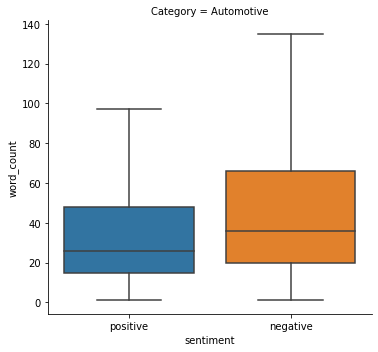

In [374]:
sns.catplot(data = df_reviews, x = 'sentiment', y = 'word_count', 
            showfliers = False, kind = 'box', col = 'Category', col_wrap= 2)

<AxesSubplot:xlabel='sentiment', ylabel='char_count'>

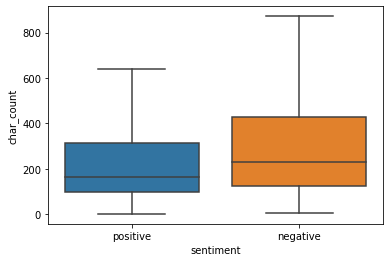

In [375]:
sns.boxplot(data = df_reviews, x = 'sentiment', y = 'char_count', showfliers = False)

/Users/mayankvarshney/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

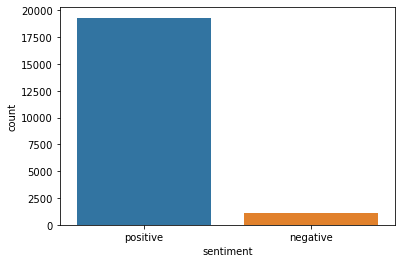

In [376]:
sns.countplot(df_reviews['sentiment'])

/Users/mayankvarshney/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='overall', ylabel='count'>

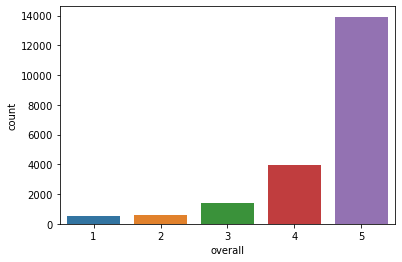

In [377]:
sns.countplot(df_reviews['overall'])

====================== B000CITK8S
2008-05-08 2014-07-08


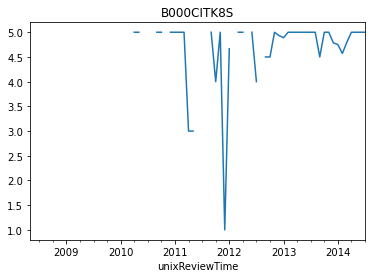




====================== B007TG7HFO
2012-09-24 2014-07-14


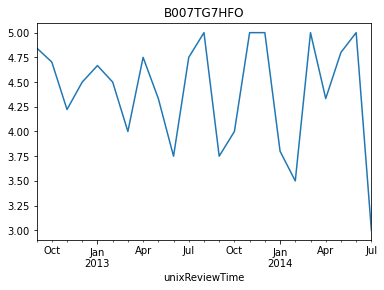




====================== B001V8U12M
2011-05-05 2014-07-10


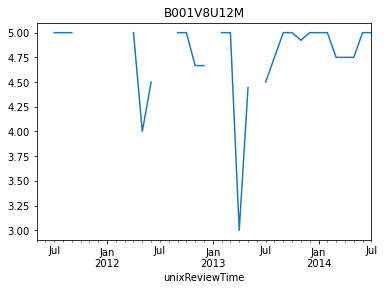




====================== B002BC4N5I
2010-12-06 2014-07-08


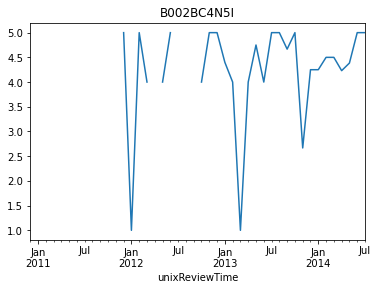




====================== B002OUMVWY
2010-08-30 2014-07-11


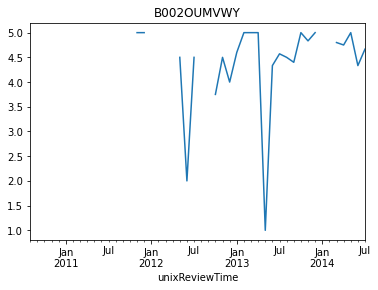

In [378]:
top5asin= df_reviews['asin'].value_counts().head().index

for a in top5asin:
    temp = df_reviews[df_reviews['asin'] == a]
    print('======================', a)
    print(temp['unixReviewTime'].min(),temp['unixReviewTime'].max())
    temp2 = temp.overall.resample('M').mean()
    temp2.plot()
    plt.title(a)
    plt.show()
    print('\n'*2)
    

In [379]:
df_top= df_reviews.groupby(['sentiment','asin'], as_index= False)['Clean_Reviews'].count()
df_top.head()

,sentiment,asin,Clean_Reviews
0,negative,B00008RW9U,1
1,negative,B0000AXPDU,1
2,negative,B0000AXRH5,1
3,negative,B0000AXY62,1
4,negative,B0000AY60S,1


,sentiment,asin,Clean_Reviews
417,negative,B002BC4N5I,10
261,negative,B000RGQ4Q6,10
54,negative,B0002Z9L8K,9
234,negative,B000M5UD1E,9
674,negative,B00CCOBOI4,9


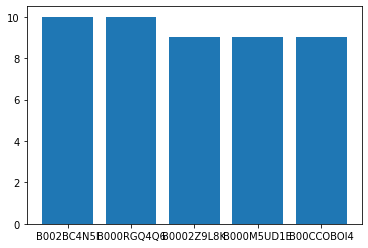

,sentiment,asin,Clean_Reviews
1164,positive,B000CITK8S,165
2343,positive,B007TG7HFO,111
1776,positive,B001V8U12M,110
1828,positive,B002BC4N5I,80
1885,positive,B002OUMVWY,79


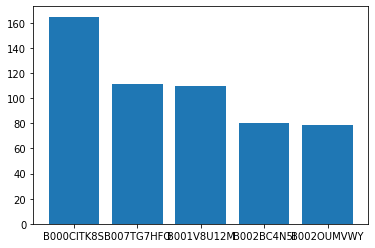

In [380]:
for s in df_top['sentiment'].unique():
    temp = df_top[df_top['sentiment'] == s].sort_values(by = 'Clean_Reviews', ascending = False).head()
    display(temp)
    plt.bar(x= temp.asin.values, height = temp.Clean_Reviews.values)
    plt.show()